In [ ]:
#pip install numpy

In [ ]:
#pip install pandas

In [ ]:
#pip install matplotlib

In [ ]:
#pip install seaborn

In [ ]:
#pip install statsmodels

In [ ]:
#pip install scikit-learn

In [ ]:
#pip install pmdarima

In [ ]:
#pip install optuna

In [ ]:
#pip install prophet

In [ ]:
#pip install plotly

In [38]:
#pip install pickle

ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle
Note: you may need to restart the kernel to use updated packages.


# Imports

In [ ]:
# List of all imports
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import optuna
import pickle

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from datetime import datetime

from prophet import Prophet

# Data loading and exploration

Reading data and conversion to adequate datatypes 

In [1]:
import pandas as pd
import json

data = json.load(open('happiness_data.json'))
df = pd.DataFrame(data["objects"])

In [2]:
df

,date,score
0,2020-03-19,5.748
1,2020-03-20,5.774
2,2020-03-21,5.800
3,2020-03-22,5.781
4,2020-03-23,5.754
...,...,...
5362,2023-05-22,6.030
5363,2023-05-23,6.033
5364,2023-05-24,6.025
5365,2023-05-25,6.014


In [3]:
# Investigating data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5367 entries, 0 to 5366
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    5367 non-null   object
 1   score   5367 non-null   object
dtypes: object(2)
memory usage: 84.0+ KB


In [43]:
#from datetime import datetime

# Convert the 'date' column to datetime
df['date'] = pd.to_datetime(df['date'])

# Convert the 'score' column to float
df['score'] = df['score'].astype(float)

# Make sure dates are in ascending order
df = df.sort_values(by="date",ignore_index=True)

# Save in .csv file (for further convenience)
df.to_csv('happiness_data.csv',index=False)

Graphical visualizations: Happiness as function of time, histogram plot of values, data distribution, boxplots and elementary statistics.

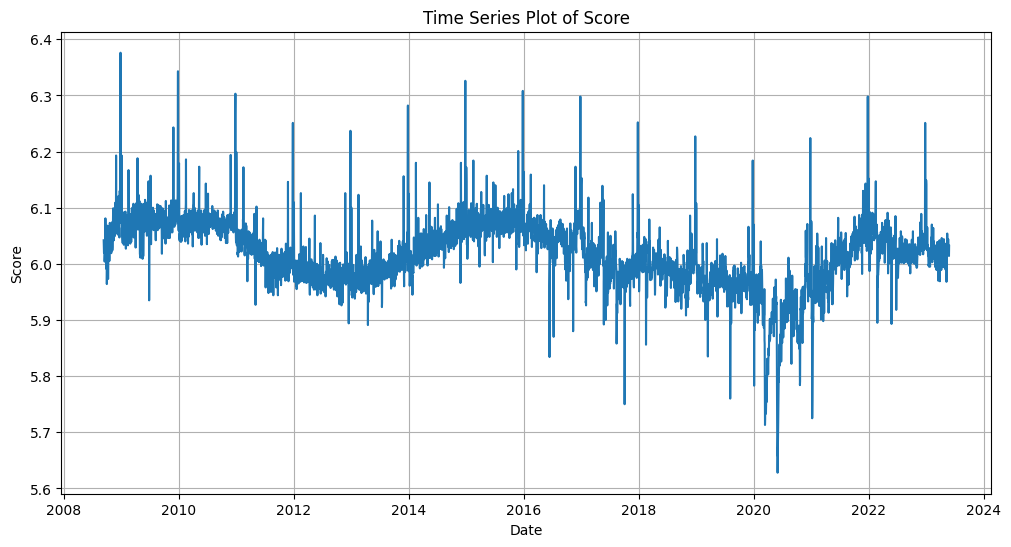

In [6]:
#import matplotlib.pyplot as plt

# Plotting the happiness time series
plt.figure(figsize=(12, 6))

plt.plot(df['date'], df['score'])
plt.xlabel('Date')
plt.ylabel('Score')
plt.title('Time Series Plot of Happiness Score')
plt.grid(True)
plt.show()

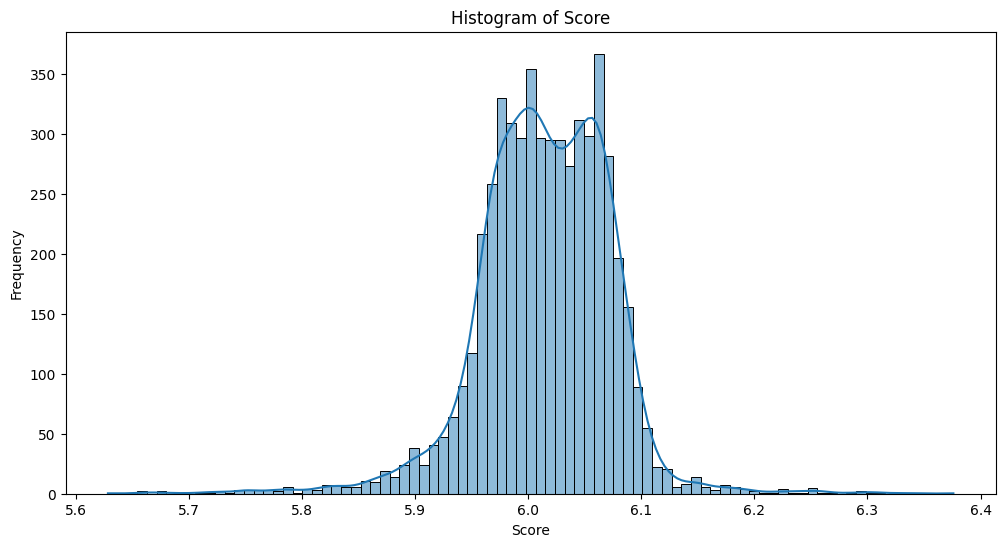

In [7]:
#import seaborn as sns

# A histogram plot of happiness values and approximate distribution
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='score', kde=True)
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Histogram of Happiness Score')
plt.show()

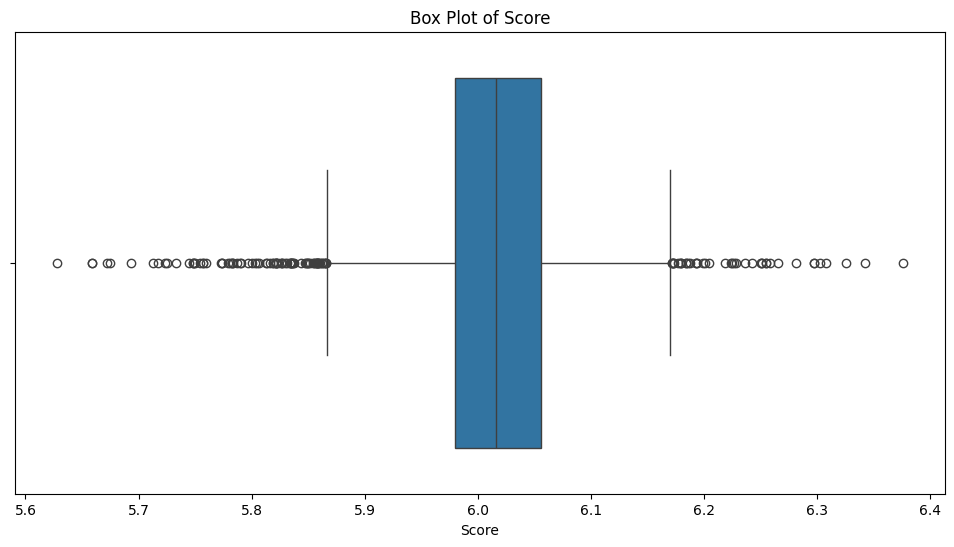

In [8]:
# Boxplot, interquantile interval and outliers
plt.figure(figsize=(12, 6))
sns.boxplot(x='score', data=df)
plt.xlabel('Score')
plt.title('Box Plot of Score')
plt.show()

In [58]:
# Fundamental statistics
print(df['score'].describe())

count    5367.000000
mean        6.015062
std         0.059059
min         5.628000
25%         5.980000
50%         6.016000
75%         6.056000
max         6.376000
Name: score, dtype: float64


# Quick overview of the situation

It seems that we are in presence of a strongly patterned time-series. On the first look, it appears to exhibit a periodicity (seasonality), or several (period-based) trends. There are also reasons to believe that it is strongly auto-regressive. This would also make sense provided the context (happiness of today is most likely to depend on that of the previous days, unless special unpredictable events). In that sense, peaks seems to represent either those unpredictable events (anomalies), or flaws in the model computation (we have no insights with this regards), and therefore outliers. In any case, those do not define the happiness variable dynamics.

We foresee the following forecasting techniques to be a good match: Moving Averages (MA), Auto-Regressive (AR), Auto-Regressive Integrated Moving Averages (ARIMA), decomposition-based methods (STL-decomposition, fbprophet).

Provided the quantity of data, deep learning techniques as LSTM can obviously be considered. Although in general, LSTM on auto-regressive data is only tracking and adjusting changes (1 day-off prediction). 

# Time-series analysis

## Auto-correlation and Partial auto-correlation functions - ACF and PACF

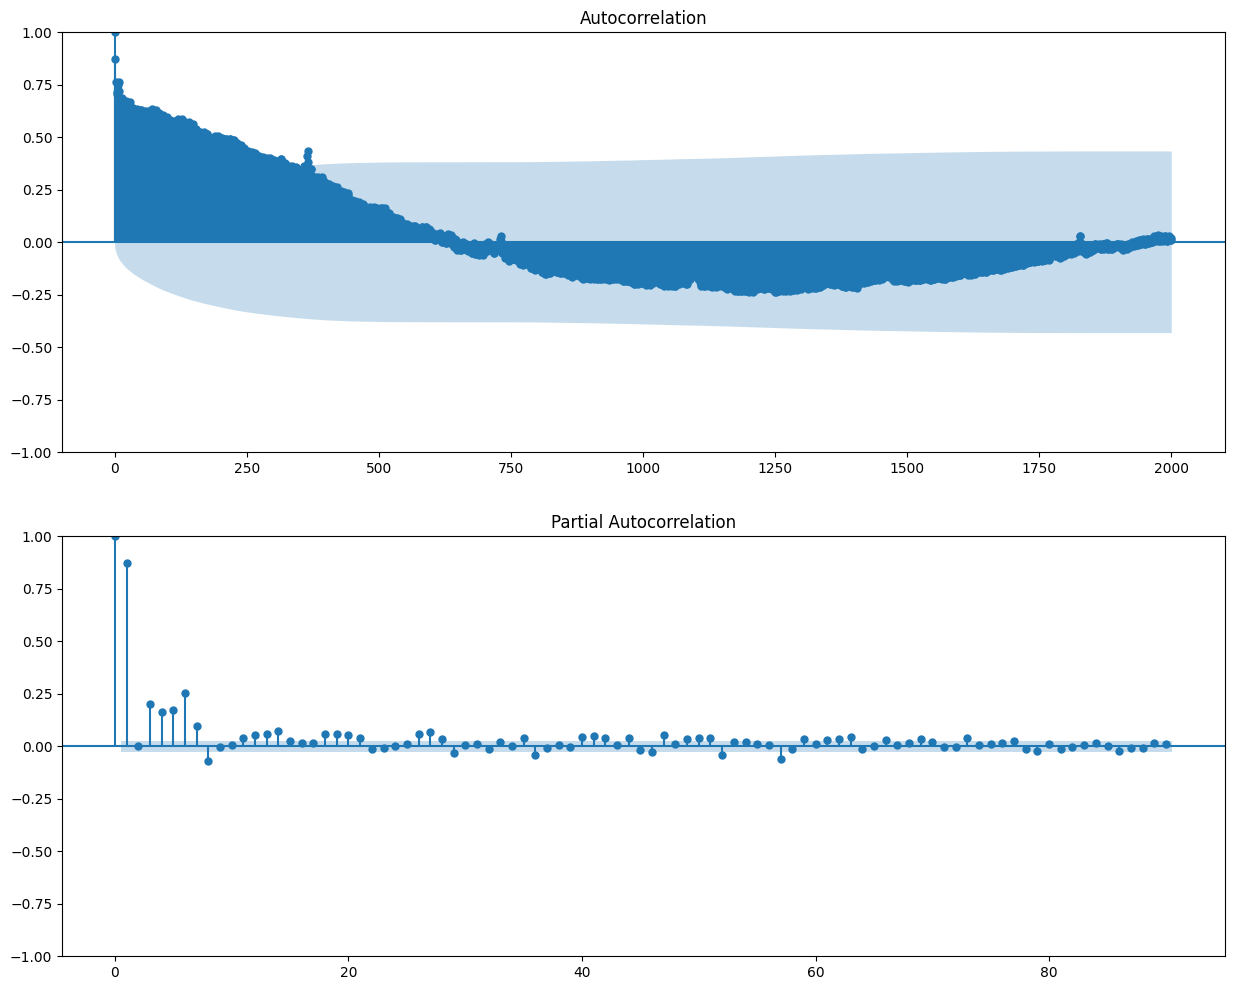

In [60]:
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
plot_acf(df['score'], lags=2000, ax=ax1)
plot_pacf(df['score'], lags=90, ax=ax2) #, method = "ols"
plt.show()

This is pretty explicit. There is clearly a strong correlation between the lagged time-series as suggested by the ACF. The correlation is decreasing in a wavy-like pattern. Combined with the information from PACF (only current additional correlation), this seems to indicate regression for about 7 days (weekly regression) and a long-term trend. It is hard though to be strongly assertive in this assumption. 

## STL-decomposition

We will be using the seasonal_decompose of statsmodels.tsa.seasonal, that does not really like missing values. There are five in this dataset, so here we are just imputting them with a forward fill, in order to to do the decomposition.

In [61]:
df_time_idx = df.copy()
df_time_idx.index = df.date
df_time_idx.drop(['date'], axis=1,inplace=True)

In [62]:
df_time_idx

,score
date,
2008-09-09,6.042
2008-09-10,6.028
2008-09-11,6.020
2008-09-12,6.028
2008-09-13,6.035
...,...
2023-05-22,6.030
2023-05-23,6.033
2023-05-24,6.025


In [13]:
# Check for missing dates
date_range_full = pd.date_range(start=df_time_idx.index.min(), end=df_time_idx.index.max(), freq='D')

missing_dates = date_range_full[~date_range_full.isin(df_time_idx.index)]

if len(missing_dates) > 0:
    print("Missing dates:")
    print(missing_dates)
else:
    print("No missing dates found.")

Missing dates:
DatetimeIndex(['2009-08-03', '2009-08-04', '2009-08-05', '2009-12-19',
               '2009-12-20', '2020-05-24'],
              dtype='datetime64[ns]', freq=None)


In [14]:
#import numpy as np

# Create a DataFrame with the new dates and NaN scores
completion_data = {'score': [np.nan] * len(missing_dates)}
completion_df = pd.DataFrame(completion_data, index=pd.to_datetime(missing_dates))

# Concatenate the original DataFrame with the new DataFrame
full_df_time_idx = pd.concat([df_time_idx, completion_df])

full_df_time_idx = full_df_time_idx.sort_index()
full_df_time_idx = full_df_time_idx.ffill()

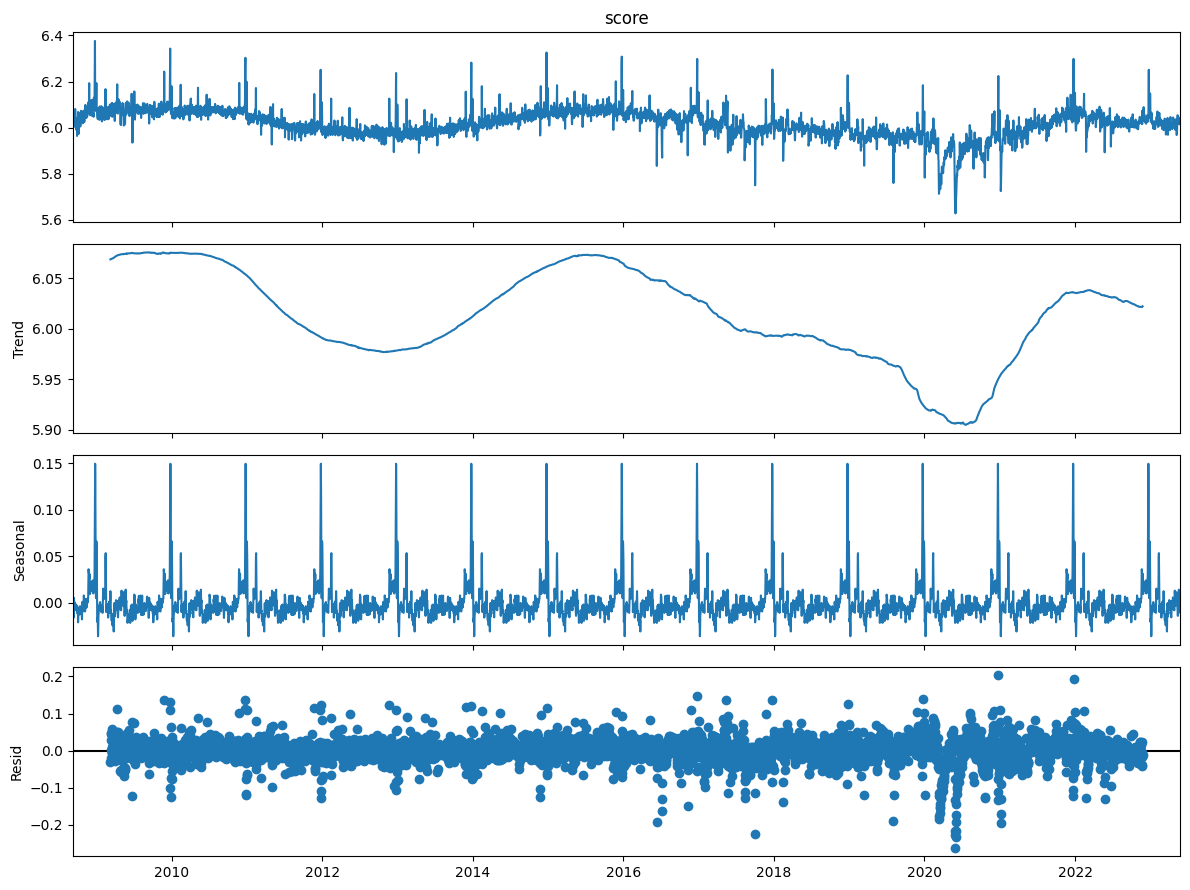

In [15]:
#from statsmodels.tsa.seasonal import seasonal_decompose


result = seasonal_decompose(full_df_time_idx['score'], model='additive',period=365)
fig = result.plot()
fig.set_size_inches((12, 9))
fig.tight_layout()
plt.show()


This, in the beginning, was quite confusing to me but in the end, I think it does make sense. Although the time-series initially looked periodic, it is most likely much more impacted by long-term "sinusoidal"-like trends, rather than seasonal effects (that would correspond to several years in this case). This is to be put in context with the current application: is happiness/mood a periodic phenomenon over several years? Probably not, but it is most likely trendy depending on the current "vibes". It is additionaly strongly regressive over the past days, not necessarily 7, but this could be considered as a nice start. 

## Stationnarity-check 

In [16]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF test
result = adfuller(df['score'])

# Extract ADF statistic and p-value
adf_statistic = result[0]
p_value = result[1]

# Define a significance level 
significance_level = 0.05

# Check stationarity based on p-value
if p_value < significance_level:
    stationarity_status = "The time series is stationary."
else:
    stationarity_status = "The time series is not stationary."

# Print the ADF statistic, p-value, and stationarity status
print(f'ADF Statistic: {adf_statistic}')
print(f'p-value: {p_value}')
print(stationarity_status)

ADF Statistic: -3.74795147998223
p-value: 0.0034870584383121755
The time series is stationary.


# Forecasting

## SARIMA-like models

Let us first have a look at how moving averages behave in this context. We also evaluate them quantitatively by looking at the RMSE: 

RMSE for Moving Average (1 days): 0.00
RMSE for Moving Average (4 days): 0.03
RMSE for Moving Average (7 days): 0.03
RMSE for Moving Average (30 days): 0.03
RMSE for Moving Average (365 days): 0.04


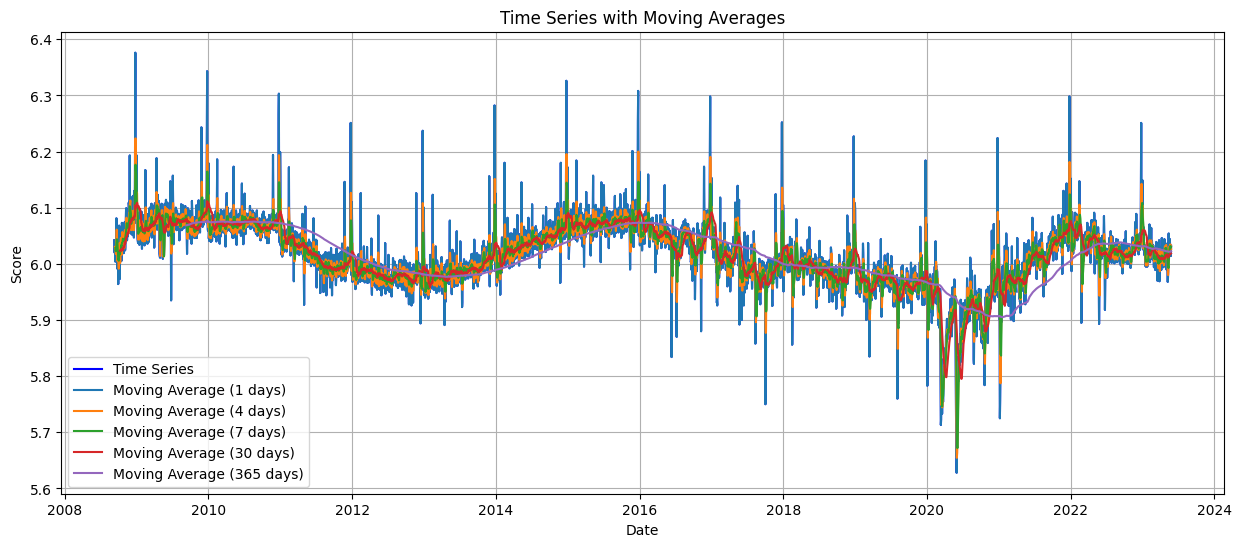

In [37]:
# Specify different moving average window sizes
window_sizes = [1,4,7,30, 365]

# Plot the time series
plt.figure(figsize=(15, 6))
plt.plot(df["date"], df['score'], label='Time Series', color='blue')

# Plot moving averages for different window sizes
rmse_values = []
for window in window_sizes:
    rolling_mean = df['score'].rolling(window=window).mean()
    plt.plot(df["date"], rolling_mean, label=f'Moving Average ({window} days)')
    
    # Calculate RMSE between the original time series and the moving average
    rmse = np.sqrt(((df['score'] - rolling_mean) ** 2).mean())
    rmse_values.append(rmse)
    print(f'RMSE for Moving Average ({window} days): {rmse:.2f}')
    
    
plt.xlabel('Date')
plt.ylabel('Score')
plt.title('Time Series with Moving Averages')
plt.legend()
plt.grid(True)
plt.show()


In [18]:
from pmdarima import auto_arima


# Use auto_arima to find the best SARIMA parameters
sarima_model = auto_arima(df['score'], seasonal=True, stepwise=True, suppress_warnings=True, error_action="ignore", max_order=None)
sarima_model.summary()

# Get the best SARIMA order
best_order = sarima_model.order
best_seasonal_order = sarima_model.seasonal_order

print(f'Best SARIMA Order: {best_order}')
print(f'Best Seasonal Order: {best_seasonal_order}')

Best SARIMA Order: (2, 1, 1)
Best Seasonal Order: (0, 0, 0, 0)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.21563D+00    |proj g|=  4.27939D-02


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      2     16      1     0     0   3.149D-03  -2.216D+00
  F =  -2.2156284498217640     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                               SARIMAX Results                                
Dep. Variable:                  score   No. Observations:                 5367
Model:               SARIMAX(7, 0, 0)   Log Likelihood               11891.278
Date:                Sun, 10 Dec 2023   AIC                         -23766.556
Time:                        15:10:06   BIC                         -23713.852
Sample:                     

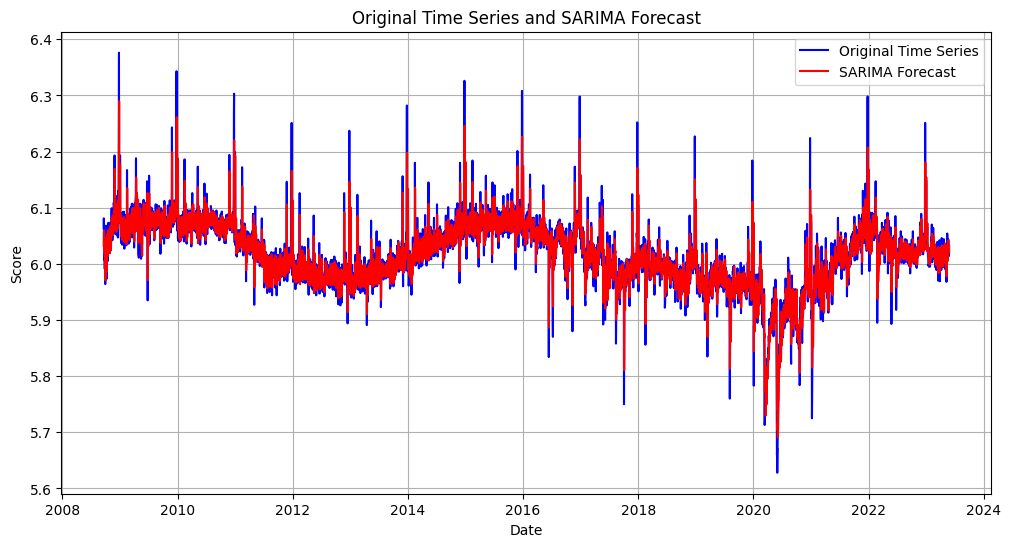

In [63]:
import statsmodels.api as sm

# Specify SARIMA parameters (p, d, q, P, D, Q, S)
p, d, q = 7, 0, 0  # Non-seasonal components
P, D, Q, S = 0, 0, 0, 0  # Seasonal components

# Create the SARIMA model
sarima_model = sm.tsa.SARIMAX(df['score'], order=(p, d, q), seasonal_order=(P, D, Q, S))

# Fit the SARIMA model to the data
sarima_result = sarima_model.fit()

# Print the model summary
print(sarima_result.summary())

# Plot the original time series and SARIMA forecast
plt.figure(figsize=(12, 6))

plt.plot(df.loc[10:,'date'], df.loc[10:,'score'], label='Original Time Series', color='blue')
plt.plot(df.loc[10:,'date'], sarima_result.fittedvalues.values[10:], label='SARIMA Forecast', color='red')

#plt.plot(df.index, df['score'], label='Original Time Series', color='blue')
#plt.plot(df.index, sarima_result.fittedvalues, label='SARIMA Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Score')
plt.title('Original Time Series and SARIMA Forecast')
plt.legend()
plt.grid(True)
plt.show()

In [64]:
from sklearn.metrics import mean_squared_error


# Make predictions on the validation set
sarima_forecast = sarima_result.get_forecast()

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(df.score.values[7:], sarima_result.fittedvalues.values[7:]))
print(f'RMSE for SARIMA Forecast: {rmse:.2f}')


RMSE for SARIMA Forecast: 0.03


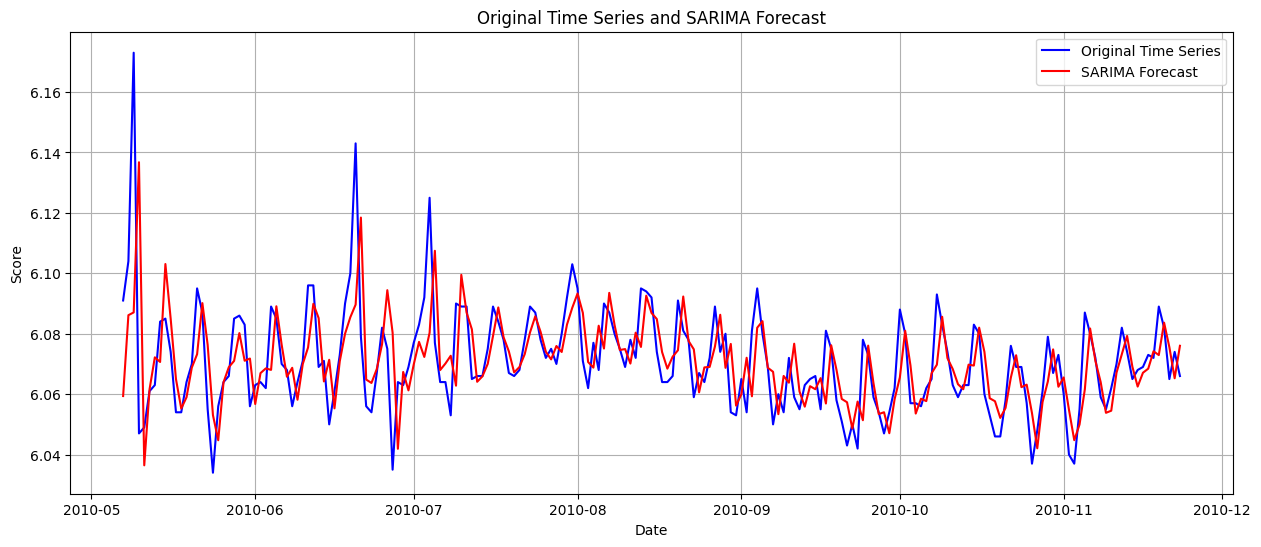

In [65]:
# Plot the original time series and SARIMA forecast
plt.figure(figsize=(15, 6))
plt.plot(df.loc[600:800,'date'], df.loc[600:800,'score'], label='Original Time Series', color='blue')
plt.plot(df.loc[600:800,'date'], sarima_result.fittedvalues.values[600:801], label='SARIMA Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Score')
plt.title('Original Time Series and SARIMA Forecast')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import optuna

# Define a function to optimize SARIMA parameters
def objective(trial):
    # Specify SARIMA parameters to search
    p = trial.suggest_int('p', 0, 10)  # Non-seasonal autoregressive order
    d = trial.suggest_int('d', 0, 2)   # Non-seasonal differencing order
    q = trial.suggest_int('q', 0, 10)  # Non-seasonal moving average order
    P = trial.suggest_int('P', 0, 10)  # Seasonal autoregressive order
    D = trial.suggest_int('D', 0, 2)   # Seasonal differencing order
    Q = trial.suggest_int('Q', 0, 10)  # Seasonal moving average order
    S = trial.suggest_int('S', 0, 10)

    try:
        # Create and fit the SARIMA model
        sarima_model = sm.tsa.SARIMAX(df['score'], order=(p, d, q), seasonal_order=(P, D, Q, S))
        sarima_result = sarima_model.fit()

        # Make predictions on the validation set
        sarima_forecast = sarima_result.get_forecast()

        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(df.score.values[7:], sarima_result.fittedvalues.values[7:]))
        return rmse

    except Exception as e:
        return float('inf')  # Return a large value for invalid parameter combinations

# Create an Optuna study and optimize SARIMA parameters
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)  # Adjust the number of trials as needed

# Print the best parameters and RMSE
best_params = study.best_params
best_rmse = study.best_value

print(f'Best SARIMA Parameters: {best_params}')
print(f'Best RMSE: {best_rmse:.2f}')


In [ ]:
#Best SARIMA Parameters: {'p': 1, 'd': 1, 'q': 1, 'P': 1, 'D': 1, 'Q': 1, 'S': 2}
#Best RMSE: 0.03

#### Small recap of (S)ARIMA-like methods

We have tried several parametrization of the SARIMA model. We used the auto_arima automated routine for evaluating optimal parameters. We have run a hyperparameter bayesian search with Optuna for evaluating optimal parameters with a different method. They indicated that optimal parameters are around 1 to 2 previous values for auto-regression, and a single moving average value. This surprisingly denied the week dependency to the profit of the real trend impact. We indeed evaluated RMSE on the full dataset and not on validation sets, based on a training, but this was simply exploration. We still see the 1-day lag phenomenon, that we foresee for LSTM-like methods.

Conclusion: RMSE is in general low, and of the same range for several attempted parametrization. SARIMA can be considered good for this case, but shall be taken with caution. There is a reason to believe that we did not really find the best parametrization nonetheless, and if not for time lack we would have conducted more research. We decided to go though for the trend descriptive models, fbprophet, since a trend effect is clearly there. The second reason for that is that they are more robust to long-term predictions. SARIMA is a short-term prediction, that needs real data adjustement. 

## FB-prophet

In [30]:
df_fb = df.copy()
df_fb.rename(columns={"date": "ds", "score": "y"},inplace=True)

In [66]:
#from prophet import Prophet

11:12:14 - cmdstanpy - INFO - Chain [1] start processing
11:12:15 - cmdstanpy - INFO - Chain [1] done processing
/Users/yasmineelayeb/miniconda3/envs/datascience/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/yasmineelayeb/miniconda3/envs/datascience/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


<Figure size 1500x600 with 0 Axes>

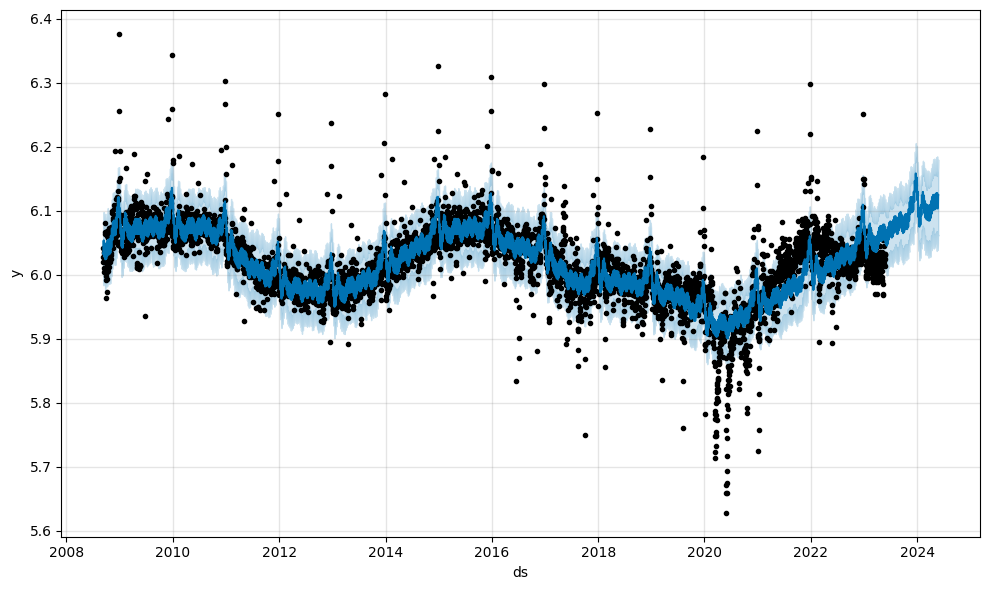

In [36]:
# Create a Prophet model
model = Prophet()

# Fit the model to the data
model.fit(df_fb)

# Create a future dataframe for forecasting
future = model.make_future_dataframe(periods=365)  # Forecast for the next 7 days

# Generate forecasts
forecast = model.predict(future)

# Plot the forecast
plt.figure(figsize=(15, 6))
fig = model.plot(forecast)
plt.show()

In [40]:
#import pickle

with open('prophet_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)
    